# 1D Audio CNN Model

This code is adapted from content from my Masters Course at UAL

Data set: https://jazzomat.hfm-weimar.de/dbformat/dbcontent.html  

This code implements a 1-Dimensional Convoluitonal Neural Network that classifies raw waveforms of people speaking different voice instructions. The CNN model implemented here is based on this paper: https://arxiv.org/pdf/1610.00087.pdf

The code in this notebook is heavily modified (for readability and adaptability) from this soruce: https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html

#### LLM Disclaimer
Throughout this notebook and project, code has been adapted from online sorces and LLMs. They have been cited where they were used. 


In [4]:
# Imports
import torch

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchaudio.transforms as transforms 

from tqdm import tqdm #Progress bars during training
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Import data util functions from 'src/'
from src.audio_folder_dataset import AudioFolder
from src.audio_folder_collate_fn import collate_audio_folder_batch

### Defining the hyperparameters

Here I set the device to 'mps' as I worked from my Macbook with an M3 Pro chip. This did appear to accelerate the learning. 

I experimented with various new sample rates, epochs, batch sizes etc.

In [5]:
device = 'mps'
original_sample_rate = 44100 # Sample rate for the speech commands dataset
new_sample_rate = 11025 # Sample rate for the speech commands dataset
val_size = 0.3 # Size of train / validation split
batch_size = 50 # Batch size for training
num_epochs = 100 # Number of epochs for training (this is a large dataset so not many epochs needed)
log_interval = 50 # Log process every n interations
learning_rate = 0.001 # Learning rate for training
weight_decay = 0.0001 # Weight decay for ADAM optimiser

### Define data transform

This function downsamples the audio waveform from a sample rate of 44100 to 22050, which helps the model train more efficiently.


In [6]:
transform = transforms.Resample(orig_freq=original_sample_rate, new_freq=new_sample_rate)

### Create datasets

Here the wav files are loaded in and split into test and training batches.  

In [7]:
train_path = '/Users/loiskelly/Documents/GitHub/ai4mediaproject/data/wav_folders_split'
dataset = AudioFolder(train_path, transform=transform)
num_classes = len(dataset.classes)
print(dataset.classes)

# Get length of dataset and indicies
num_train = len(dataset)
indices = list(range(num_train))

# Get train / val split for data points
train_indices, val_indices = train_test_split(indices, test_size=val_size, random_state=42)

# Override dataset classes to only be samples for each split
train_subset = torch.utils.data.Subset(dataset, train_indices)
val_subset = torch.utils.data.Subset(dataset, val_indices)

# Create data loaders - these feed baches of data during training. 
train_loader = DataLoader(train_subset, batch_size=batch_size, collate_fn=collate_audio_folder_batch, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, collate_fn=collate_audio_folder_batch,  shuffle=False)


['ArtPepper', 'BenWebster', 'BennyCarter', 'BennyGoodman', 'BixBeiderbecke', 'BobBerg', 'BranfordMarsalis', 'BuckClayton', 'CannonballAdderley', 'CharlieParker', 'CharlieShavers', 'ChetBaker', 'ChrisPotter', 'ChuBerry', 'CliffordBrown', 'ColemanHawkins', 'CurtisFuller', 'DavidLiebman', 'DavidMurray', 'DexterGordon', 'DickieWells', 'DizzyGillespie', 'DonByas', 'DonEllis', 'EricDolphy', 'FatsNavarro', 'FreddieHubbard', 'GeorgeColeman', 'GerryMulligan', 'HankMobley', 'HarryEdison', 'HenryAllen', 'HerbieHancock', 'JCHigginbotham', 'JJJohnson', 'JoeHenderson', 'JoeLovano', 'JohnAbercrombie', 'JohnColtrane', 'JohnnyDodds', 'JohnnyHodges', 'JoshuaRedman', 'KaiWinding', 'KennyDorham', 'KennyGarrett', 'KennyWheeler', 'KidOry', 'LeeKonitz', 'LeeMorgan', 'LesterYoung', 'LionelHampton', 'LouisArmstrong', 'MichaelBrecker', 'MilesDavis', 'MiltJackson', 'NatAdderley', 'OrnetteColeman', 'PatMartino', 'PatMetheny', 'PaulDesmond', 'PepperAdams', 'PhilWoods', 'RedGarland', 'RexStewart', 'RoyEldridge', 'S

### Plot a sample of the data

In [ ]:
data_batch, label_batch = next(iter(train_loader))
sample_waveform = data_batch[0].squeeze()
print(f'Data batch shape: {data_batch.shape}')
print(f"Shape of waveform: {sample_waveform.size()}")
sample_class = int(label_batch[0].item())
print(f'Class of waveform: \'{dataset.idx_to_class[sample_class]}\'')
plt.plot(sample_waveform.t().numpy())

### Define the Network

Here we define a 1-Dimensional convolutional neural network to process raw audio data. The specific architecture is modeled after the M5 network architecture described in [this paper](https://arxiv.org/pdf/1610.00087.pdf). 



In [9]:
class M5(nn.Module):
    def __init__(self, n_input=50, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return x

### Setup core objects

Here we setup our core objects, the model, the loss function (criterion) and the optimiser.

In [10]:
model = M5(n_input=1, n_output=num_classes)
model.to(device)
print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n = count_parameters(model)
print("Number of parameters: %s" % n)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=78, bias=True)
)
Numbe

### Evaluation functions

These are functions we can use to get the actual prediction from the model in validation to get an overall accuracy score on the validation set:

In [11]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

### Training loop


Here is our training loop for our data. Look at how the training set and validation set are used differently. 

In [12]:
pbar_update = 1 / (len(train_loader) + len(val_loader))

train_losses = []
val_losses = []

best_loss = 100000

# Show progress bar 
with tqdm(total=num_epochs) as pbar:
    
    # For each cycle of the dataset
    for epoch in range(num_epochs):
        # Variables to keep track of running loss
        train_loss = 0.0
        val_loss = 0.0
        
        # Put model in training model
        model.train()
        model.to(device)
        
        # Train loop
        # For each batch in one cycle of the training set
        for batch_idx, (data, target) in enumerate(train_loader):
            pass
            # Move data to whatever device we are running training on
            data = data.to(device)
            target = target.to(device)
            
            # Forward pass with the model
            output = model(data)

            # Evaluate classification accuracy
            loss = criterion(output.squeeze(), target)
            
            # Backpropagate loss and update gradients
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Keep track off loss over time
            train_loss += loss.item()

            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

            # update progress bar
            pbar.update(pbar_update)

        # Put model in evaluation mode (turn off batch norm)
        model.eval()
        model.to(device)
        # Without gradient tracking 
        with torch.no_grad():
            
            # Variable to track total correct classifications
            correct = 0

            # Validation loop
            # For each batch in one cycle of the validation set
            for data, target in val_loader:
                
                # Move data to whatever device we are running training on
                data = data.to(device)
                target = target.to(device)

                # Forward pass with the model
                output = model(data)

                # Evaluate classification accuracy
                loss = criterion(output.squeeze(), target)
                
                # Track loss
                val_loss += loss.item()

                # Get top prediction
                pred = get_likely_index(output)
                
                # Check if prediction is correct
                correct += number_of_correct(pred, target)

                # update progress bar
                pbar.update(pbar_update)
        
        # Normalise cumulative losses to dataset size
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        
        # Added cumulative losses to lists for later display
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(val_loader.dataset)} ({100. * correct / len(val_loader.dataset):.0f}%)\n")

        # if validation score is lowest so far, save the model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.cpu().state_dict(), 'best_audio_classifier.pt')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0.01092896174863388/100 [00:03<8:00:22, 288.26s/it] 

Train Epoch: 0 [0/6370 (0%)]	Loss: 4.398822


  0%|          | 0.2841530054644811/100 [00:11<42:33, 25.61s/it]    

Train Epoch: 0 [2500/6370 (39%)]	Loss: 3.905454


  1%|          | 0.5573770491803284/100 [00:18<41:12, 24.87s/it] 

Train Epoch: 0 [5000/6370 (78%)]	Loss: 3.600441


  1%|          | 1.0054644808743178/100 [00:32<53:47, 32.60s/it]  


Test Epoch: 0	Accuracy: 281/2730 (10%)

Train Epoch: 1 [0/6370 (0%)]	Loss: 3.785722


  1%|▏         | 1.284153005464482/100 [00:39<40:35, 24.67s/it] 

Train Epoch: 1 [2500/6370 (39%)]	Loss: 3.514519


  2%|▏         | 1.5573770491803294/100 [00:46<37:34, 22.90s/it]

Train Epoch: 1 [5000/6370 (78%)]	Loss: 3.669513


  2%|▏         | 2.0054644808743185/100 [00:58<44:28, 27.23s/it]


Test Epoch: 1	Accuracy: 320/2730 (12%)

Train Epoch: 2 [0/6370 (0%)]	Loss: 3.697466


  2%|▏         | 2.2841530054644714/100 [01:05<38:45, 23.80s/it]

Train Epoch: 2 [2500/6370 (39%)]	Loss: 3.398362


  3%|▎         | 2.5573770491803076/100 [01:11<37:05, 22.84s/it]

Train Epoch: 2 [5000/6370 (78%)]	Loss: 3.579942


  3%|▎         | 3.005464480874279/100 [01:23<46:12, 28.58s/it] 


Test Epoch: 2	Accuracy: 348/2730 (13%)

Train Epoch: 3 [0/6370 (0%)]	Loss: 3.570124


  3%|▎         | 3.284153005464432/100 [01:30<40:19, 25.02s/it] 

Train Epoch: 3 [2500/6370 (39%)]	Loss: 3.397188


  4%|▎         | 3.557377049180268/100 [01:37<37:49, 23.53s/it] 

Train Epoch: 3 [5000/6370 (78%)]	Loss: 3.347522


  4%|▍         | 4.00546448087424/100 [01:49<42:17, 26.43s/it]  


Test Epoch: 3	Accuracy: 392/2730 (14%)

Train Epoch: 4 [0/6370 (0%)]	Loss: 3.276505


  4%|▍         | 4.2841530054644155/100 [01:56<39:54, 25.01s/it]

Train Epoch: 4 [2500/6370 (39%)]	Loss: 3.499374


  5%|▍         | 4.557377049180274/100 [02:03<36:47, 23.12s/it] 

Train Epoch: 4 [5000/6370 (78%)]	Loss: 3.414300


  5%|▌         | 5.005464480874282/100 [02:15<45:39, 28.84s/it] 


Test Epoch: 4	Accuracy: 454/2730 (17%)

Train Epoch: 5 [0/6370 (0%)]	Loss: 3.187863


  5%|▌         | 5.284153005464457/100 [02:22<38:35, 24.45s/it] 

Train Epoch: 5 [2500/6370 (39%)]	Loss: 3.502586


  6%|▌         | 5.557377049180316/100 [02:28<37:58, 24.13s/it] 

Train Epoch: 5 [5000/6370 (78%)]	Loss: 3.064291


  6%|▌         | 6.005464480874323/100 [02:40<43:11, 27.58s/it] 


Test Epoch: 5	Accuracy: 477/2730 (17%)

Train Epoch: 6 [0/6370 (0%)]	Loss: 3.242995


  6%|▋         | 6.284153005464499/100 [02:48<39:47, 25.48s/it] 

Train Epoch: 6 [2500/6370 (39%)]	Loss: 3.289782


  7%|▋         | 6.557377049180357/100 [02:54<39:42, 25.50s/it] 

Train Epoch: 6 [5000/6370 (78%)]	Loss: 3.285527


  7%|▋         | 7.005464480874365/100 [03:06<43:02, 27.77s/it] 


Test Epoch: 6	Accuracy: 466/2730 (17%)

Train Epoch: 7 [0/6370 (0%)]	Loss: 2.761456


  7%|▋         | 7.284153005464541/100 [03:13<37:36, 24.34s/it] 

Train Epoch: 7 [2500/6370 (39%)]	Loss: 3.056248


  8%|▊         | 7.557377049180399/100 [03:20<40:55, 26.56s/it] 

Train Epoch: 7 [5000/6370 (78%)]	Loss: 2.910558


  8%|▊         | 8.005464480874405/100 [03:32<42:49, 27.93s/it] 


Test Epoch: 7	Accuracy: 513/2730 (19%)

Train Epoch: 8 [0/6370 (0%)]	Loss: 2.902064


  8%|▊         | 8.284153005464535/100 [03:39<39:00, 25.52s/it]

Train Epoch: 8 [2500/6370 (39%)]	Loss: 3.051206


  9%|▊         | 8.55737704918035/100 [03:46<35:33, 23.33s/it] 

Train Epoch: 8 [5000/6370 (78%)]	Loss: 3.058123


  9%|▉         | 9.005464480874284/100 [03:57<42:26, 27.98s/it]


Test Epoch: 8	Accuracy: 520/2730 (19%)

Train Epoch: 9 [0/6370 (0%)]	Loss: 2.791898


  9%|▉         | 9.284153005464415/100 [04:05<37:25, 24.76s/it]

Train Epoch: 9 [2500/6370 (39%)]	Loss: 2.859232


 10%|▉         | 9.557377049180229/100 [04:11<35:55, 23.84s/it]

Train Epoch: 9 [5000/6370 (78%)]	Loss: 3.147194


 10%|█         | 10.005464480874164/100 [04:23<40:45, 27.18s/it]


Test Epoch: 9	Accuracy: 515/2730 (19%)

Train Epoch: 10 [0/6370 (0%)]	Loss: 3.299390


 10%|█         | 10.284153005464294/100 [04:30<37:00, 24.75s/it]

Train Epoch: 10 [2500/6370 (39%)]	Loss: 2.844541


 11%|█         | 10.557377049180108/100 [04:37<36:09, 24.26s/it]

Train Epoch: 10 [5000/6370 (78%)]	Loss: 3.350578


 11%|█         | 11.005464480874043/100 [04:49<41:41, 28.10s/it]  


Test Epoch: 10	Accuracy: 596/2730 (22%)

Train Epoch: 11 [0/6370 (0%)]	Loss: 2.735675


 11%|█▏        | 11.284153005464173/100 [04:57<38:29, 26.03s/it]

Train Epoch: 11 [2500/6370 (39%)]	Loss: 2.623210


 12%|█▏        | 11.557377049179987/100 [05:04<40:13, 27.29s/it]

Train Epoch: 11 [5000/6370 (78%)]	Loss: 2.992217


 12%|█▏        | 12.005464480873922/100 [05:17<43:50, 29.90s/it]


Test Epoch: 11	Accuracy: 586/2730 (21%)

Train Epoch: 12 [0/6370 (0%)]	Loss: 2.652614


 12%|█▏        | 12.284153005464052/100 [05:26<38:43, 26.49s/it]

Train Epoch: 12 [2500/6370 (39%)]	Loss: 2.763459


 13%|█▎        | 12.557377049179866/100 [05:32<35:24, 24.29s/it]

Train Epoch: 12 [5000/6370 (78%)]	Loss: 3.326647


 13%|█▎        | 13.005464480873801/100 [05:45<40:20, 27.82s/it]  


Test Epoch: 12	Accuracy: 566/2730 (21%)

Train Epoch: 13 [0/6370 (0%)]	Loss: 2.708642


 13%|█▎        | 13.284153005463931/100 [05:52<35:46, 24.75s/it]

Train Epoch: 13 [2500/6370 (39%)]	Loss: 2.921403


 14%|█▎        | 13.557377049179745/100 [05:58<33:34, 23.31s/it]

Train Epoch: 13 [5000/6370 (78%)]	Loss: 2.490507


 14%|█▍        | 14.00546448087368/100 [06:12<45:07, 31.49s/it] 


Test Epoch: 13	Accuracy: 591/2730 (22%)

Train Epoch: 14 [0/6370 (0%)]	Loss: 2.930469


 14%|█▍        | 14.28415300546381/100 [06:20<39:38, 27.75s/it] 

Train Epoch: 14 [2500/6370 (39%)]	Loss: 2.472202


 15%|█▍        | 14.557377049179625/100 [06:27<37:50, 26.57s/it]

Train Epoch: 14 [5000/6370 (78%)]	Loss: 3.039501


 15%|█▌        | 15.00546448087356/100 [06:40<41:50, 29.54s/it] 


Test Epoch: 14	Accuracy: 607/2730 (22%)

Train Epoch: 15 [0/6370 (0%)]	Loss: 2.757421


 15%|█▌        | 15.28415300546369/100 [06:48<39:02, 27.65s/it] 

Train Epoch: 15 [2500/6370 (39%)]	Loss: 2.865156


 16%|█▌        | 15.557377049179504/100 [06:55<35:46, 25.42s/it]

Train Epoch: 15 [5000/6370 (78%)]	Loss: 2.645489


 16%|█▌        | 16.00546448087344/100 [07:08<39:04, 27.91s/it] 


Test Epoch: 15	Accuracy: 650/2730 (24%)

Train Epoch: 16 [0/6370 (0%)]	Loss: 2.735356


 16%|█▋        | 16.28415300546357/100 [07:16<33:35, 24.07s/it] 

Train Epoch: 16 [2500/6370 (39%)]	Loss: 2.671156


 17%|█▋        | 16.557377049179383/100 [07:23<34:07, 24.54s/it]

Train Epoch: 16 [5000/6370 (78%)]	Loss: 3.021234


 17%|█▋        | 17.005464480873318/100 [07:36<42:19, 30.60s/it]


Test Epoch: 16	Accuracy: 643/2730 (24%)

Train Epoch: 17 [0/6370 (0%)]	Loss: 2.654824


 17%|█▋        | 17.28415300546345/100 [07:44<37:33, 27.25s/it] 

Train Epoch: 17 [2500/6370 (39%)]	Loss: 2.536810


 18%|█▊        | 17.557377049179262/100 [07:51<37:11, 27.07s/it]

Train Epoch: 17 [5000/6370 (78%)]	Loss: 2.405851


 18%|█▊        | 18.005464480873197/100 [08:04<39:49, 29.14s/it]


Test Epoch: 17	Accuracy: 584/2730 (21%)

Train Epoch: 18 [0/6370 (0%)]	Loss: 2.810755


 18%|█▊        | 18.284153005463327/100 [08:12<38:21, 28.17s/it]

Train Epoch: 18 [2500/6370 (39%)]	Loss: 2.602799


 19%|█▊        | 18.55737704917914/100 [08:20<34:20, 25.30s/it] 

Train Epoch: 18 [5000/6370 (78%)]	Loss: 2.915648


 19%|█▉        | 19.005464480873076/100 [08:33<45:09, 33.45s/it]


Test Epoch: 18	Accuracy: 668/2730 (24%)

Train Epoch: 19 [0/6370 (0%)]	Loss: 2.476382


 19%|█▉        | 19.284153005463207/100 [08:41<39:29, 29.36s/it]

Train Epoch: 19 [2500/6370 (39%)]	Loss: 2.701483


 20%|█▉        | 19.55737704917902/100 [08:48<36:41, 27.37s/it] 

Train Epoch: 19 [5000/6370 (78%)]	Loss: 2.240740


 20%|█▉        | 19.99999999999864/100 [09:02<41:10, 30.88s/it] 


Test Epoch: 19	Accuracy: 661/2730 (24%)



 20%|██        | 20.010928961747272/100 [09:02<44:23, 33.30s/it]

Train Epoch: 20 [0/6370 (0%)]	Loss: 2.422799


 20%|██        | 20.284153005463086/100 [09:10<38:24, 28.91s/it]

Train Epoch: 20 [2500/6370 (39%)]	Loss: 2.589799


 21%|██        | 20.5573770491789/100 [09:18<35:30, 26.82s/it]  

Train Epoch: 20 [5000/6370 (78%)]	Loss: 2.475866


 21%|██        | 21.005464480872835/100 [09:31<43:14, 32.84s/it]


Test Epoch: 20	Accuracy: 631/2730 (23%)

Train Epoch: 21 [0/6370 (0%)]	Loss: 2.688466


 21%|██▏       | 21.284153005462965/100 [09:39<34:00, 25.93s/it]

Train Epoch: 21 [2500/6370 (39%)]	Loss: 2.314754


 22%|██▏       | 21.55737704917878/100 [09:46<34:30, 26.39s/it] 

Train Epoch: 21 [5000/6370 (78%)]	Loss: 2.492720


 22%|██▏       | 22.005464480872714/100 [10:00<42:13, 32.48s/it]


Test Epoch: 21	Accuracy: 694/2730 (25%)

Train Epoch: 22 [0/6370 (0%)]	Loss: 2.408988


 22%|██▏       | 22.284153005462844/100 [10:08<37:42, 29.11s/it]

Train Epoch: 22 [2500/6370 (39%)]	Loss: 2.665833


 23%|██▎       | 22.55737704917866/100 [10:16<39:21, 30.49s/it] 

Train Epoch: 22 [5000/6370 (78%)]	Loss: 2.537468


 23%|██▎       | 23.005464480872593/100 [10:28<37:29, 29.21s/it]


Test Epoch: 22	Accuracy: 658/2730 (24%)

Train Epoch: 23 [0/6370 (0%)]	Loss: 2.264377


 23%|██▎       | 23.284153005462723/100 [10:36<35:49, 28.02s/it]

Train Epoch: 23 [2500/6370 (39%)]	Loss: 2.533360


 24%|██▎       | 23.557377049178537/100 [10:43<35:04, 27.53s/it]

Train Epoch: 23 [5000/6370 (78%)]	Loss: 2.770298


 24%|██▍       | 24.005464480872472/100 [10:56<36:37, 28.91s/it]


Test Epoch: 23	Accuracy: 663/2730 (24%)

Train Epoch: 24 [0/6370 (0%)]	Loss: 2.368146


 24%|██▍       | 24.284153005462603/100 [11:04<35:32, 28.16s/it]

Train Epoch: 24 [2500/6370 (39%)]	Loss: 2.429051


 25%|██▍       | 24.557377049178417/100 [11:11<33:36, 26.73s/it]

Train Epoch: 24 [5000/6370 (78%)]	Loss: 2.472533


 25%|██▌       | 25.00546448087235/100 [11:24<39:39, 31.73s/it] 


Test Epoch: 24	Accuracy: 664/2730 (24%)

Train Epoch: 25 [0/6370 (0%)]	Loss: 2.745430


 25%|██▌       | 25.284153005462482/100 [11:32<34:08, 27.42s/it]

Train Epoch: 25 [2500/6370 (39%)]	Loss: 2.388246


 26%|██▌       | 25.557377049178296/100 [11:40<33:16, 26.82s/it]

Train Epoch: 25 [5000/6370 (78%)]	Loss: 2.298038


 26%|██▌       | 26.00546448087223/100 [11:53<35:59, 29.19s/it] 


Test Epoch: 25	Accuracy: 703/2730 (26%)

Train Epoch: 26 [0/6370 (0%)]	Loss: 2.376659


 26%|██▋       | 26.28415300546236/100 [12:00<30:39, 24.95s/it] 

Train Epoch: 26 [2500/6370 (39%)]	Loss: 2.481820


 27%|██▋       | 26.557377049178175/100 [12:07<31:57, 26.10s/it]

Train Epoch: 26 [5000/6370 (78%)]	Loss: 2.093824


 27%|██▋       | 27.00546448087211/100 [12:19<34:25, 28.29s/it] 


Test Epoch: 26	Accuracy: 685/2730 (25%)

Train Epoch: 27 [0/6370 (0%)]	Loss: 2.231421


 27%|██▋       | 27.28415300546224/100 [12:26<31:06, 25.67s/it] 

Train Epoch: 27 [2500/6370 (39%)]	Loss: 2.148373


 28%|██▊       | 27.557377049178054/100 [12:33<29:37, 24.54s/it]

Train Epoch: 27 [5000/6370 (78%)]	Loss: 2.531750


 28%|██▊       | 28.00546448087199/100 [12:45<33:51, 28.22s/it] 


Test Epoch: 27	Accuracy: 671/2730 (25%)

Train Epoch: 28 [0/6370 (0%)]	Loss: 2.283594


 28%|██▊       | 28.28415300546212/100 [12:53<30:30, 25.52s/it] 

Train Epoch: 28 [2500/6370 (39%)]	Loss: 2.283394


 29%|██▊       | 28.557377049177934/100 [12:59<28:28, 23.92s/it]

Train Epoch: 28 [5000/6370 (78%)]	Loss: 2.385953


 29%|██▉       | 29.00546448087187/100 [13:12<34:14, 28.94s/it] 


Test Epoch: 28	Accuracy: 698/2730 (26%)

Train Epoch: 29 [0/6370 (0%)]	Loss: 2.029836


 29%|██▉       | 29.284153005462/100 [13:19<30:12, 25.63s/it]   

Train Epoch: 29 [2500/6370 (39%)]	Loss: 2.247369


 30%|██▉       | 29.557377049177813/100 [13:26<28:18, 24.10s/it]

Train Epoch: 29 [5000/6370 (78%)]	Loss: 2.352926


 30%|███       | 30.005464480871748/100 [13:38<33:16, 28.52s/it]


Test Epoch: 29	Accuracy: 678/2730 (25%)

Train Epoch: 30 [0/6370 (0%)]	Loss: 2.273705


 30%|███       | 30.284153005461878/100 [13:45<28:14, 24.31s/it]

Train Epoch: 30 [2500/6370 (39%)]	Loss: 2.701171


 31%|███       | 30.557377049177692/100 [13:52<27:44, 23.97s/it]

Train Epoch: 30 [5000/6370 (78%)]	Loss: 2.336396


 31%|███       | 31.005464480871627/100 [14:04<32:50, 28.56s/it]


Test Epoch: 30	Accuracy: 722/2730 (26%)

Train Epoch: 31 [0/6370 (0%)]	Loss: 2.633617


 31%|███▏      | 31.284153005461757/100 [14:11<28:16, 24.69s/it]

Train Epoch: 31 [2500/6370 (39%)]	Loss: 2.652572


 32%|███▏      | 31.55737704917757/100 [14:18<27:25, 24.04s/it] 

Train Epoch: 31 [5000/6370 (78%)]	Loss: 2.692453


 32%|███▏      | 32.00546448087151/100 [14:31<32:04, 28.31s/it] 


Test Epoch: 31	Accuracy: 677/2730 (25%)

Train Epoch: 32 [0/6370 (0%)]	Loss: 2.107140


 32%|███▏      | 32.28415300546164/100 [14:38<28:10, 24.97s/it] 

Train Epoch: 32 [2500/6370 (39%)]	Loss: 2.231489


 33%|███▎      | 32.557377049177454/100 [14:44<26:42, 23.77s/it]

Train Epoch: 32 [5000/6370 (78%)]	Loss: 2.480394


 33%|███▎      | 33.00546448087139/100 [14:57<31:42, 28.40s/it] 


Test Epoch: 32	Accuracy: 735/2730 (27%)

Train Epoch: 33 [0/6370 (0%)]	Loss: 2.293630


 33%|███▎      | 33.28415300546152/100 [15:04<27:18, 24.57s/it] 

Train Epoch: 33 [2500/6370 (39%)]	Loss: 2.207356


 34%|███▎      | 33.55737704917733/100 [15:10<27:12, 24.57s/it] 

Train Epoch: 33 [5000/6370 (78%)]	Loss: 2.343200


 34%|███▍      | 34.00546448087127/100 [27:20<5:26:11, 296.57s/it]     


Test Epoch: 33	Accuracy: 708/2730 (26%)

Train Epoch: 34 [0/6370 (0%)]	Loss: 2.423010


 34%|███▍      | 34.2841530054614/100 [27:28<26:20, 24.05s/it]     

Train Epoch: 34 [2500/6370 (39%)]	Loss: 2.152426


 35%|███▍      | 34.55737704917721/100 [27:34<26:16, 24.09s/it] 

Train Epoch: 34 [5000/6370 (78%)]	Loss: 1.926395


 35%|███▌      | 35.00546448087115/100 [27:46<29:59, 27.68s/it] 


Test Epoch: 34	Accuracy: 757/2730 (28%)

Train Epoch: 35 [0/6370 (0%)]	Loss: 2.088232


 35%|███▌      | 35.28415300546128/100 [27:53<27:16, 25.28s/it] 

Train Epoch: 35 [2500/6370 (39%)]	Loss: 2.390640


 36%|███▌      | 35.55737704917709/100 [28:00<25:38, 23.87s/it] 

Train Epoch: 35 [5000/6370 (78%)]	Loss: 2.302678


 36%|███▌      | 36.00546448087103/100 [50:13<96:38:34, 5436.63s/it]   


Test Epoch: 35	Accuracy: 717/2730 (26%)

Train Epoch: 36 [0/6370 (0%)]	Loss: 2.214765


 36%|███▋      | 36.28415300546116/100 [50:20<27:32, 25.94s/it]      

Train Epoch: 36 [2500/6370 (39%)]	Loss: 2.082636


 37%|███▋      | 36.55737704917697/100 [50:27<26:29, 25.06s/it] 

Train Epoch: 36 [5000/6370 (78%)]	Loss: 2.289799


 37%|███▋      | 37.005464480870906/100 [50:39<29:26, 28.04s/it]


Test Epoch: 36	Accuracy: 760/2730 (28%)

Train Epoch: 37 [0/6370 (0%)]	Loss: 2.188935


 37%|███▋      | 37.284153005461036/100 [50:46<25:02, 23.96s/it]

Train Epoch: 37 [2500/6370 (39%)]	Loss: 1.855067


 38%|███▊      | 37.55737704917685/100 [50:53<23:56, 23.01s/it] 

Train Epoch: 37 [5000/6370 (78%)]	Loss: 2.252408


 38%|███▊      | 38.005464480870785/100 [51:26<28:37, 27.71s/it]    


Test Epoch: 37	Accuracy: 692/2730 (25%)

Train Epoch: 38 [0/6370 (0%)]	Loss: 2.135270


 38%|███▊      | 38.284153005460915/100 [51:33<26:51, 26.11s/it]

Train Epoch: 38 [2500/6370 (39%)]	Loss: 2.071273


 39%|███▊      | 38.55737704917673/100 [51:40<25:34, 24.97s/it] 

Train Epoch: 38 [5000/6370 (78%)]	Loss: 2.265909


 39%|███▉      | 39.005464480870664/100 [51:52<28:26, 27.98s/it]


Test Epoch: 38	Accuracy: 676/2730 (25%)

Train Epoch: 39 [0/6370 (0%)]	Loss: 1.835281


 39%|███▉      | 39.284153005460794/100 [51:59<25:01, 24.73s/it]

Train Epoch: 39 [2500/6370 (39%)]	Loss: 2.310611


 40%|███▉      | 39.55737704917661/100 [52:06<24:39, 24.47s/it] 

Train Epoch: 39 [5000/6370 (78%)]	Loss: 1.916017


 40%|████      | 40.00546448087054/100 [56:32<26:58, 26.98s/it]       


Test Epoch: 39	Accuracy: 718/2730 (26%)

Train Epoch: 40 [0/6370 (0%)]	Loss: 2.250723


 40%|████      | 40.284153005460674/100 [56:39<24:06, 24.22s/it]

Train Epoch: 40 [2500/6370 (39%)]	Loss: 2.241044


 41%|████      | 40.55737704917649/100 [56:46<22:20, 22.55s/it] 

Train Epoch: 40 [5000/6370 (78%)]	Loss: 1.973095


 41%|████      | 41.00546448087042/100 [56:58<27:20, 27.81s/it] 


Test Epoch: 40	Accuracy: 734/2730 (27%)

Train Epoch: 41 [0/6370 (0%)]	Loss: 2.538571


 41%|████▏     | 41.28415300546055/100 [57:04<24:10, 24.70s/it] 

Train Epoch: 41 [2500/6370 (39%)]	Loss: 2.222399


 42%|████▏     | 41.55737704917637/100 [57:44<22:42, 23.31s/it]      

Train Epoch: 41 [5000/6370 (78%)]	Loss: 2.021390


 42%|████▏     | 42.0054644808703/100 [57:56<26:17, 27.21s/it]  


Test Epoch: 41	Accuracy: 700/2730 (26%)

Train Epoch: 42 [0/6370 (0%)]	Loss: 2.028072


 42%|████▏     | 42.28415300546043/100 [58:03<24:43, 25.70s/it] 

Train Epoch: 42 [2500/6370 (39%)]	Loss: 2.023379


 43%|████▎     | 42.557377049176246/100 [58:10<22:08, 23.13s/it]

Train Epoch: 42 [5000/6370 (78%)]	Loss: 2.161581


 43%|████▎     | 43.00546448087018/100 [58:22<26:06, 27.49s/it] 


Test Epoch: 42	Accuracy: 731/2730 (27%)

Train Epoch: 43 [0/6370 (0%)]	Loss: 1.884131


 43%|████▎     | 43.28415300546031/100 [1:07:04<30:32, 32.31s/it]       

Train Epoch: 43 [2500/6370 (39%)]	Loss: 2.309969


 44%|████▎     | 43.557377049176125/100 [1:07:10<23:13, 24.68s/it]

Train Epoch: 43 [5000/6370 (78%)]	Loss: 2.287027


 44%|████▍     | 44.00546448087006/100 [1:07:22<25:38, 27.47s/it] 


Test Epoch: 43	Accuracy: 753/2730 (28%)

Train Epoch: 44 [0/6370 (0%)]	Loss: 1.923625


 44%|████▍     | 44.28415300546019/100 [1:07:29<22:08, 23.84s/it] 

Train Epoch: 44 [2500/6370 (39%)]	Loss: 1.909375


 45%|████▍     | 44.557377049176004/100 [1:07:36<22:10, 24.01s/it]

Train Epoch: 44 [5000/6370 (78%)]	Loss: 2.216265


 45%|████▍     | 44.99999999999562/100 [1:12:14<54:12:59, 3548.72s/it]   


Test Epoch: 44	Accuracy: 755/2730 (28%)



 45%|████▌     | 45.010928961744256/100 [1:12:15<26:51:09, 1757.98s/it]

Train Epoch: 45 [0/6370 (0%)]	Loss: 1.945584


 45%|████▌     | 45.28415300546007/100 [1:12:22<22:28, 24.64s/it]      

Train Epoch: 45 [2500/6370 (39%)]	Loss: 2.142882


 46%|████▌     | 45.557377049175884/100 [1:12:28<20:52, 23.01s/it]

Train Epoch: 45 [5000/6370 (78%)]	Loss: 2.333172


 46%|████▌     | 46.00546448086982/100 [1:12:41<24:52, 27.63s/it] 


Test Epoch: 45	Accuracy: 772/2730 (28%)

Train Epoch: 46 [0/6370 (0%)]	Loss: 1.910751


 46%|████▋     | 46.28415300545995/100 [1:12:48<22:06, 24.70s/it] 

Train Epoch: 46 [2500/6370 (39%)]	Loss: 2.030431


 47%|████▋     | 46.55737704917576/100 [1:12:54<21:16, 23.89s/it] 

Train Epoch: 46 [5000/6370 (78%)]	Loss: 2.234255


 47%|████▋     | 47.0054644808697/100 [1:19:33<24:09, 27.35s/it]        


Test Epoch: 46	Accuracy: 710/2730 (26%)

Train Epoch: 47 [0/6370 (0%)]	Loss: 2.050442


 47%|████▋     | 47.28415300545983/100 [1:19:40<22:27, 25.56s/it] 

Train Epoch: 47 [2500/6370 (39%)]	Loss: 2.254934


 48%|████▊     | 47.55737704917564/100 [1:19:46<21:30, 24.61s/it] 

Train Epoch: 47 [5000/6370 (78%)]	Loss: 1.892974


 48%|████▊     | 48.00546448086958/100 [1:19:58<24:08, 27.87s/it] 


Test Epoch: 47	Accuracy: 691/2730 (25%)

Train Epoch: 48 [0/6370 (0%)]	Loss: 1.830008


 48%|████▊     | 48.28415300545971/100 [1:20:05<20:17, 23.54s/it] 

Train Epoch: 48 [2500/6370 (39%)]	Loss: 1.822313


 49%|████▊     | 48.55737704917552/100 [1:20:12<21:31, 25.11s/it] 

Train Epoch: 48 [5000/6370 (78%)]	Loss: 1.736928


 49%|████▉     | 49.005464480869456/100 [1:27:08<23:36, 27.78s/it]       


Test Epoch: 48	Accuracy: 720/2730 (26%)

Train Epoch: 49 [0/6370 (0%)]	Loss: 2.043779


 49%|████▉     | 49.284153005459586/100 [1:27:15<21:22, 25.29s/it]

Train Epoch: 49 [2500/6370 (39%)]	Loss: 1.981508


 50%|████▉     | 49.5573770491754/100 [1:27:21<20:49, 24.76s/it]  

Train Epoch: 49 [5000/6370 (78%)]	Loss: 2.021190


 50%|█████     | 50.005464480869335/100 [1:27:33<23:20, 28.01s/it]


Test Epoch: 49	Accuracy: 718/2730 (26%)

Train Epoch: 50 [0/6370 (0%)]	Loss: 1.682336


 50%|█████     | 50.284153005459466/100 [1:27:40<19:45, 23.84s/it]

Train Epoch: 50 [2500/6370 (39%)]	Loss: 2.250337


 51%|█████     | 50.55737704917528/100 [1:33:28<20:24, 24.77s/it]        

Train Epoch: 50 [5000/6370 (78%)]	Loss: 2.011495


 51%|█████     | 51.005464480869215/100 [1:33:40<22:42, 27.82s/it]


Test Epoch: 50	Accuracy: 727/2730 (27%)

Train Epoch: 51 [0/6370 (0%)]	Loss: 1.764809


 51%|█████▏    | 51.284153005459345/100 [1:33:47<20:49, 25.66s/it]

Train Epoch: 51 [2500/6370 (39%)]	Loss: 2.020231


 52%|█████▏    | 51.55737704917516/100 [1:33:54<20:09, 24.97s/it] 

Train Epoch: 51 [5000/6370 (78%)]	Loss: 2.263924


 52%|█████▏    | 52.005464480869094/100 [1:34:06<22:06, 27.64s/it]


Test Epoch: 51	Accuracy: 755/2730 (28%)

Train Epoch: 52 [0/6370 (0%)]	Loss: 2.022139


 52%|█████▏    | 52.284153005459224/100 [1:42:10<23:22, 29.39s/it]      

Train Epoch: 52 [2500/6370 (39%)]	Loss: 1.950803


 53%|█████▎    | 52.55737704917504/100 [1:42:16<18:29, 23.39s/it] 

Train Epoch: 52 [5000/6370 (78%)]	Loss: 2.293644


 53%|█████▎    | 53.00546448086897/100 [1:42:28<21:44, 27.76s/it] 


Test Epoch: 52	Accuracy: 753/2730 (28%)

Train Epoch: 53 [0/6370 (0%)]	Loss: 1.713286


 53%|█████▎    | 53.2841530054591/100 [1:42:35<19:37, 25.20s/it]  

Train Epoch: 53 [2500/6370 (39%)]	Loss: 1.764782


 54%|█████▎    | 53.55737704917492/100 [1:42:42<17:47, 22.99s/it] 

Train Epoch: 53 [5000/6370 (78%)]	Loss: 1.772595


 54%|█████▍    | 54.00546448086885/100 [1:42:56<22:56, 29.92s/it]   


Test Epoch: 53	Accuracy: 765/2730 (28%)

Train Epoch: 54 [0/6370 (0%)]	Loss: 1.807325


 54%|█████▍    | 54.28415300545898/100 [1:43:03<18:01, 23.66s/it] 

Train Epoch: 54 [2500/6370 (39%)]	Loss: 1.716432


 55%|█████▍    | 54.5573770491748/100 [1:43:09<18:58, 25.06s/it]  

Train Epoch: 54 [5000/6370 (78%)]	Loss: 1.804827


 55%|█████▌    | 55.00546448086873/100 [1:43:21<20:31, 27.36s/it] 


Test Epoch: 54	Accuracy: 783/2730 (29%)

Train Epoch: 55 [0/6370 (0%)]	Loss: 2.008993


 55%|█████▌    | 55.28415300545886/100 [1:43:28<18:44, 25.14s/it] 

Train Epoch: 55 [2500/6370 (39%)]	Loss: 1.589691


 56%|█████▌    | 55.557377049174676/100 [1:43:35<17:30, 23.64s/it]

Train Epoch: 55 [5000/6370 (78%)]	Loss: 1.898504


 56%|█████▌    | 56.00546448086861/100 [1:50:48<19:47, 26.99s/it]        


Test Epoch: 55	Accuracy: 750/2730 (27%)

Train Epoch: 56 [0/6370 (0%)]	Loss: 1.540730


 56%|█████▋    | 56.28415300545874/100 [1:50:55<17:15, 23.70s/it] 

Train Epoch: 56 [2500/6370 (39%)]	Loss: 1.803941


 57%|█████▋    | 56.557377049174555/100 [1:51:02<17:03, 23.55s/it]

Train Epoch: 56 [5000/6370 (78%)]	Loss: 1.680819


 57%|█████▋    | 57.00546448086849/100 [1:51:14<19:48, 27.64s/it] 


Test Epoch: 56	Accuracy: 709/2730 (26%)

Train Epoch: 57 [0/6370 (0%)]	Loss: 1.628688


 57%|█████▋    | 57.28415300545862/100 [1:51:21<17:13, 24.20s/it] 

Train Epoch: 57 [2500/6370 (39%)]	Loss: 1.757424


 58%|█████▊    | 57.557377049174434/100 [1:51:27<17:09, 24.25s/it]

Train Epoch: 57 [5000/6370 (78%)]	Loss: 1.803563


 58%|█████▊    | 58.00546448086837/100 [2:39:51<6:26:19, 551.98s/it]     


Test Epoch: 57	Accuracy: 759/2730 (28%)

Train Epoch: 58 [0/6370 (0%)]	Loss: 1.999834


 58%|█████▊    | 58.2841530054585/100 [2:41:24<17:47, 25.60s/it]       

Train Epoch: 58 [2500/6370 (39%)]	Loss: 2.055449


 59%|█████▊    | 58.55737704917431/100 [2:41:31<16:41, 24.17s/it] 

Train Epoch: 58 [5000/6370 (78%)]	Loss: 2.042644


 59%|█████▉    | 59.00546448086825/100 [2:41:44<19:15, 28.19s/it] 


Test Epoch: 58	Accuracy: 736/2730 (27%)

Train Epoch: 59 [0/6370 (0%)]	Loss: 1.760242


 59%|█████▉    | 59.28415300545838/100 [2:41:51<16:16, 23.99s/it] 

Train Epoch: 59 [2500/6370 (39%)]	Loss: 1.811864


 60%|█████▉    | 59.55737704917419/100 [2:41:58<16:05, 23.87s/it] 

Train Epoch: 59 [5000/6370 (78%)]	Loss: 2.133299


 60%|██████    | 60.00546448086813/100 [2:56:03<25:42, 38.56s/it]        


Test Epoch: 59	Accuracy: 784/2730 (29%)

Train Epoch: 60 [0/6370 (0%)]	Loss: 1.607324


 60%|██████    | 60.28415300545826/100 [2:56:09<14:49, 22.39s/it] 

Train Epoch: 60 [2500/6370 (39%)]	Loss: 1.719714


 61%|██████    | 60.55737704917407/100 [2:56:15<14:25, 21.95s/it] 

Train Epoch: 60 [5000/6370 (78%)]	Loss: 1.958375


 61%|██████    | 61.00546448086801/100 [2:56:25<13:28, 20.74s/it] 


Test Epoch: 60	Accuracy: 710/2730 (26%)

Train Epoch: 61 [0/6370 (0%)]	Loss: 1.693324


 61%|██████▏   | 61.28415300545814/100 [2:56:32<14:33, 22.55s/it] 

Train Epoch: 61 [2500/6370 (39%)]	Loss: 1.722686


 62%|██████▏   | 61.55737704917395/100 [2:56:38<14:19, 22.35s/it] 

Train Epoch: 61 [5000/6370 (78%)]	Loss: 1.824111


 62%|██████▏   | 62.005464480867886/100 [3:14:16<4:44:37, 449.46s/it]    


Test Epoch: 61	Accuracy: 731/2730 (27%)

Train Epoch: 62 [0/6370 (0%)]	Loss: 1.554203


 62%|██████▏   | 62.284153005458016/100 [3:27:54<18:12, 28.98s/it]       

Train Epoch: 62 [2500/6370 (39%)]	Loss: 1.892450


 63%|██████▎   | 62.55737704917383/100 [3:28:00<14:07, 22.64s/it] 

Train Epoch: 62 [5000/6370 (78%)]	Loss: 2.021837


 63%|██████▎   | 63.005464480867765/100 [3:28:10<12:47, 20.76s/it]


Test Epoch: 62	Accuracy: 746/2730 (27%)

Train Epoch: 63 [0/6370 (0%)]	Loss: 1.514026


 63%|██████▎   | 63.284153005457895/100 [3:28:17<13:45, 22.50s/it]

Train Epoch: 63 [2500/6370 (39%)]	Loss: 1.858255


 64%|██████▎   | 63.55737704917371/100 [3:28:23<13:56, 22.95s/it] 

Train Epoch: 63 [5000/6370 (78%)]	Loss: 2.087876


 64%|██████▍   | 64.00546448086764/100 [3:28:33<12:22, 20.63s/it] 


Test Epoch: 63	Accuracy: 737/2730 (27%)

Train Epoch: 64 [0/6370 (0%)]	Loss: 1.722272


 64%|██████▍   | 64.28415300545814/100 [3:46:12<5:46:44, 582.50s/it]    

Train Epoch: 64 [2500/6370 (39%)]	Loss: 1.987357


 65%|██████▍   | 64.5573770491743/100 [4:01:36<21:27, 36.32s/it]        

Train Epoch: 64 [5000/6370 (78%)]	Loss: 1.833364


 65%|██████▌   | 65.00546448086882/100 [4:01:46<12:04, 20.70s/it]


Test Epoch: 64	Accuracy: 705/2730 (26%)

Train Epoch: 65 [0/6370 (0%)]	Loss: 1.117733


 65%|██████▌   | 65.28415300545932/100 [4:01:53<12:49, 22.17s/it]

Train Epoch: 65 [2500/6370 (39%)]	Loss: 1.719470


 66%|██████▌   | 65.55737704917549/100 [4:01:59<13:06, 22.85s/it]

Train Epoch: 65 [5000/6370 (78%)]	Loss: 1.703344


 66%|██████▌   | 66.00546448087/100 [4:02:09<12:01, 21.22s/it]   


Test Epoch: 65	Accuracy: 733/2730 (27%)

Train Epoch: 66 [0/6370 (0%)]	Loss: 1.589462


 66%|██████▋   | 66.2841530054605/100 [4:02:15<12:50, 22.85s/it] 

Train Epoch: 66 [2500/6370 (39%)]	Loss: 1.936594


 67%|██████▋   | 66.55737704917667/100 [4:19:14<5:12:44, 561.10s/it]    

Train Epoch: 66 [5000/6370 (78%)]	Loss: 1.304336


 67%|██████▋   | 67.00546448087118/100 [4:52:02<3:40:18, 400.64s/it]    


Test Epoch: 66	Accuracy: 683/2730 (25%)

Train Epoch: 67 [0/6370 (0%)]	Loss: 1.951325


 67%|██████▋   | 67.28415300546168/100 [5:07:23<15:58, 29.30s/it]       

Train Epoch: 67 [2500/6370 (39%)]	Loss: 1.672715


 68%|██████▊   | 67.55737704917784/100 [5:07:29<12:22, 22.88s/it]

Train Epoch: 67 [5000/6370 (78%)]	Loss: 1.697061


 68%|██████▊   | 68.00546448087236/100 [5:07:39<10:59, 20.61s/it]


Test Epoch: 67	Accuracy: 738/2730 (27%)

Train Epoch: 68 [0/6370 (0%)]	Loss: 1.607045


 68%|██████▊   | 68.28415300546285/100 [5:07:45<11:45, 22.25s/it]

Train Epoch: 68 [2500/6370 (39%)]	Loss: 1.586434


 69%|██████▊   | 68.55737704917902/100 [5:07:51<11:38, 22.23s/it]

Train Epoch: 68 [5000/6370 (78%)]	Loss: 1.540637


 69%|██████▉   | 69.00546448087354/100 [5:08:01<10:36, 20.54s/it]


Test Epoch: 68	Accuracy: 736/2730 (27%)

Train Epoch: 69 [0/6370 (0%)]	Loss: 1.654488


 69%|██████▉   | 69.28415300546403/100 [5:24:42<27:02:48, 3169.98s/it]  

Train Epoch: 69 [2500/6370 (39%)]	Loss: 1.792563


 70%|██████▉   | 69.5573770491802/100 [5:40:27<53:48, 106.06s/it]       

Train Epoch: 69 [5000/6370 (78%)]	Loss: 1.641183


 70%|███████   | 70.00546448087472/100 [6:12:03<42:17, 84.60s/it]       


Test Epoch: 69	Accuracy: 716/2730 (26%)

Train Epoch: 70 [0/6370 (0%)]	Loss: 1.659223


 70%|███████   | 70.28415300546521/100 [6:28:29<12:51, 25.95s/it]       

Train Epoch: 70 [2500/6370 (39%)]	Loss: 1.828934


 71%|███████   | 70.55191256830706/100 [6:45:04<11:16, 22.97s/it]       

Train Epoch: 70 [5000/6370 (78%)]	Loss: 1.580028


 71%|███████   | 70.99453551912725/100 [7:17:01<10:43, 22.18s/it]       


Test Epoch: 70	Accuracy: 727/2730 (27%)



 71%|███████   | 71.01092896175022/100 [7:32:23<235:43:26, 29273.33s/it]

Train Epoch: 71 [0/6370 (0%)]	Loss: 1.437747


 71%|███████▏  | 71.2841530054664/100 [7:50:24<9:29:27, 1189.85s/it]    

Train Epoch: 71 [2500/6370 (39%)]	Loss: 1.705005


 72%|███████▏  | 71.55737704918256/100 [8:07:32<25:42, 54.23s/it]       

Train Epoch: 71 [5000/6370 (78%)]	Loss: 1.986930


 72%|███████▏  | 72.00546448087708/100 [8:19:11<09:39, 20.71s/it]       


Test Epoch: 71	Accuracy: 743/2730 (27%)

Train Epoch: 72 [0/6370 (0%)]	Loss: 1.409550


 72%|███████▏  | 72.28415300546757/100 [8:19:18<10:25, 22.56s/it]

Train Epoch: 72 [2500/6370 (39%)]	Loss: 1.947865


 73%|███████▎  | 72.55737704918374/100 [8:19:24<10:17, 22.51s/it]

Train Epoch: 72 [5000/6370 (78%)]	Loss: 1.802972


 73%|███████▎  | 73.00546448087826/100 [8:19:33<08:38, 19.19s/it]


Test Epoch: 72	Accuracy: 730/2730 (27%)

Train Epoch: 73 [0/6370 (0%)]	Loss: 1.857961


 73%|███████▎  | 73.28415300546875/100 [8:19:40<09:45, 21.90s/it]

Train Epoch: 73 [2500/6370 (39%)]	Loss: 1.509138


 74%|███████▎  | 73.55737704918492/100 [8:19:46<10:06, 22.95s/it]

Train Epoch: 73 [5000/6370 (78%)]	Loss: 1.872249


 74%|███████▍  | 74.00546448087944/100 [8:29:07<08:58, 20.72s/it]       


Test Epoch: 73	Accuracy: 716/2730 (26%)

Train Epoch: 74 [0/6370 (0%)]	Loss: 1.562962


 74%|███████▍  | 74.28415300546993/100 [8:29:14<09:39, 22.52s/it]

Train Epoch: 74 [2500/6370 (39%)]	Loss: 2.028533


 75%|███████▍  | 74.5573770491861/100 [8:29:20<09:30, 22.42s/it] 

Train Epoch: 74 [5000/6370 (78%)]	Loss: 1.673037


 75%|███████▌  | 75.00546448088062/100 [8:29:30<08:36, 20.67s/it]


Test Epoch: 74	Accuracy: 701/2730 (26%)

Train Epoch: 75 [0/6370 (0%)]	Loss: 1.480499


 75%|███████▌  | 75.28415300547111/100 [8:29:36<09:15, 22.46s/it]

Train Epoch: 75 [2500/6370 (39%)]	Loss: 1.630906


 76%|███████▌  | 75.55737704918728/100 [8:29:42<09:13, 22.63s/it]

Train Epoch: 75 [5000/6370 (78%)]	Loss: 1.698115


 76%|███████▌  | 76.0054644808818/100 [8:47:12<18:02, 45.10s/it]        


Test Epoch: 75	Accuracy: 730/2730 (27%)

Train Epoch: 76 [0/6370 (0%)]	Loss: 1.620081


 76%|███████▋  | 76.28415300547229/100 [8:57:16<09:10, 23.23s/it]       

Train Epoch: 76 [2500/6370 (39%)]	Loss: 1.569751


 77%|███████▋  | 76.55737704918846/100 [8:57:22<09:02, 23.12s/it]

Train Epoch: 76 [5000/6370 (78%)]	Loss: 1.539487


 77%|███████▋  | 77.00546448088298/100 [8:57:32<07:53, 20.61s/it]


Test Epoch: 76	Accuracy: 697/2730 (26%)

Train Epoch: 77 [0/6370 (0%)]	Loss: 1.624928


 77%|███████▋  | 77.28415300547347/100 [8:57:38<08:28, 22.38s/it]

Train Epoch: 77 [2500/6370 (39%)]	Loss: 1.914225


 78%|███████▊  | 77.55737704918964/100 [8:57:44<08:18, 22.21s/it]

Train Epoch: 77 [5000/6370 (78%)]	Loss: 1.800550


 78%|███████▊  | 78.00546448088416/100 [8:57:54<07:33, 20.61s/it]


Test Epoch: 77	Accuracy: 745/2730 (27%)

Train Epoch: 78 [0/6370 (0%)]	Loss: 1.898276


 78%|███████▊  | 78.28415300547465/100 [9:06:43<42:38, 117.84s/it]      

Train Epoch: 78 [2500/6370 (39%)]	Loss: 1.958336


 79%|███████▊  | 78.55737704919082/100 [9:06:49<08:01, 22.48s/it] 

Train Epoch: 78 [5000/6370 (78%)]	Loss: 1.639344


 79%|███████▉  | 79.00546448088534/100 [9:06:59<07:11, 20.56s/it]


Test Epoch: 78	Accuracy: 718/2730 (26%)

Train Epoch: 79 [0/6370 (0%)]	Loss: 1.632924


 79%|███████▉  | 79.28415300547583/100 [9:07:06<07:49, 22.65s/it]

Train Epoch: 79 [2500/6370 (39%)]	Loss: 1.670971


 80%|███████▉  | 79.557377049192/100 [9:07:12<07:36, 22.33s/it]  

Train Epoch: 79 [5000/6370 (78%)]	Loss: 1.515728


 80%|████████  | 80.00546448088652/100 [9:07:22<06:49, 20.46s/it]


Test Epoch: 79	Accuracy: 737/2730 (27%)

Train Epoch: 80 [0/6370 (0%)]	Loss: 1.517294


 80%|████████  | 80.27868852460269/100 [9:07:28<07:18, 22.25s/it]

Train Epoch: 80 [2500/6370 (39%)]	Loss: 1.597372


 81%|████████  | 80.55737704919318/100 [9:13:57<07:22, 22.78s/it]       

Train Epoch: 80 [5000/6370 (78%)]	Loss: 1.960625


 81%|████████  | 81.0054644808877/100 [9:14:06<06:28, 20.46s/it] 


Test Epoch: 80	Accuracy: 715/2730 (26%)

Train Epoch: 81 [0/6370 (0%)]	Loss: 1.547410


 81%|████████▏ | 81.28415300547819/100 [9:14:13<06:59, 22.44s/it]

Train Epoch: 81 [2500/6370 (39%)]	Loss: 1.348000


 82%|████████▏ | 81.55737704919436/100 [9:14:19<06:44, 21.92s/it]

Train Epoch: 81 [5000/6370 (78%)]	Loss: 1.540751


 82%|████████▏ | 82.00546448088888/100 [9:14:29<06:12, 20.73s/it]


Test Epoch: 81	Accuracy: 772/2730 (28%)

Train Epoch: 82 [0/6370 (0%)]	Loss: 1.659752


 82%|████████▏ | 82.28415300547937/100 [9:14:35<06:34, 22.27s/it]

Train Epoch: 82 [2500/6370 (39%)]	Loss: 1.380640


 83%|████████▎ | 82.55737704919554/100 [9:16:05<06:28, 22.25s/it]     

Train Epoch: 82 [5000/6370 (78%)]	Loss: 1.408794


 83%|████████▎ | 83.00546448089005/100 [9:16:15<05:47, 20.44s/it]


Test Epoch: 82	Accuracy: 721/2730 (26%)

Train Epoch: 83 [0/6370 (0%)]	Loss: 1.878350


 83%|████████▎ | 83.28415300548055/100 [9:16:21<06:14, 22.38s/it]

Train Epoch: 83 [2500/6370 (39%)]	Loss: 1.480448


 84%|████████▎ | 83.55737704919672/100 [9:16:27<06:06, 22.32s/it]

Train Epoch: 83 [5000/6370 (78%)]	Loss: 1.727464


 84%|████████▍ | 84.00546448089123/100 [9:16:37<05:34, 20.91s/it]


Test Epoch: 83	Accuracy: 739/2730 (27%)

Train Epoch: 84 [0/6370 (0%)]	Loss: 1.406078


 84%|████████▍ | 84.28415300548173/100 [9:16:43<05:47, 22.11s/it]

Train Epoch: 84 [2500/6370 (39%)]	Loss: 1.478676


 85%|████████▍ | 84.5573770491979/100 [9:33:53<29:16, 113.74s/it]       

Train Epoch: 84 [5000/6370 (78%)]	Loss: 1.726794


 85%|████████▌ | 85.00546448089241/100 [9:37:01<05:11, 20.76s/it]     


Test Epoch: 84	Accuracy: 751/2730 (28%)

Train Epoch: 85 [0/6370 (0%)]	Loss: 1.197752


 85%|████████▌ | 85.2841530054829/100 [9:37:07<05:26, 22.16s/it] 

Train Epoch: 85 [2500/6370 (39%)]	Loss: 1.674654


 86%|████████▌ | 85.55737704919908/100 [9:37:13<05:30, 22.92s/it]

Train Epoch: 85 [5000/6370 (78%)]	Loss: 1.857635


 86%|████████▌ | 86.0054644808936/100 [9:37:24<04:45, 20.42s/it] 


Test Epoch: 85	Accuracy: 750/2730 (27%)

Train Epoch: 86 [0/6370 (0%)]	Loss: 1.153286


 86%|████████▋ | 86.28415300548409/100 [9:37:30<05:04, 22.21s/it]

Train Epoch: 86 [2500/6370 (39%)]	Loss: 1.167185


 87%|████████▋ | 86.55737704920026/100 [9:37:36<05:07, 22.89s/it]

Train Epoch: 86 [5000/6370 (78%)]	Loss: 1.718797


 87%|████████▋ | 87.00546448089477/100 [9:37:49<04:41, 21.64s/it] 


Test Epoch: 86	Accuracy: 749/2730 (27%)

Train Epoch: 87 [0/6370 (0%)]	Loss: 1.802917


 87%|████████▋ | 87.28415300548527/100 [9:37:56<04:49, 22.78s/it]

Train Epoch: 87 [2500/6370 (39%)]	Loss: 1.481939


 88%|████████▊ | 87.55737704920143/100 [9:38:02<04:41, 22.66s/it]

Train Epoch: 87 [5000/6370 (78%)]	Loss: 1.436121


 88%|████████▊ | 88.00546448089595/100 [9:38:12<04:07, 20.60s/it]


Test Epoch: 87	Accuracy: 737/2730 (27%)

Train Epoch: 88 [0/6370 (0%)]	Loss: 1.230667


 88%|████████▊ | 88.28415300548644/100 [9:38:18<04:28, 22.88s/it]

Train Epoch: 88 [2500/6370 (39%)]	Loss: 1.431729


 89%|████████▊ | 88.55737704920261/100 [9:38:24<04:18, 22.61s/it]

Train Epoch: 88 [5000/6370 (78%)]	Loss: 1.435838


 89%|████████▉ | 89.00546448089713/100 [9:41:45<03:43, 20.33s/it]      


Test Epoch: 88	Accuracy: 744/2730 (27%)

Train Epoch: 89 [0/6370 (0%)]	Loss: 1.261914


 89%|████████▉ | 89.28415300548762/100 [9:41:51<04:02, 22.64s/it]

Train Epoch: 89 [2500/6370 (39%)]	Loss: 1.498736


 90%|████████▉ | 89.5573770492038/100 [9:41:57<03:54, 22.43s/it] 

Train Epoch: 89 [5000/6370 (78%)]	Loss: 1.679727


 90%|█████████ | 90.00546448089831/100 [9:42:07<03:24, 20.48s/it]


Test Epoch: 89	Accuracy: 724/2730 (27%)

Train Epoch: 90 [0/6370 (0%)]	Loss: 1.214670


 90%|█████████ | 90.2841530054888/100 [9:42:13<03:35, 22.21s/it] 

Train Epoch: 90 [2500/6370 (39%)]	Loss: 1.525141


 91%|█████████ | 90.55737704920497/100 [9:42:19<03:33, 22.58s/it]

Train Epoch: 90 [5000/6370 (78%)]	Loss: 1.407190


 91%|█████████ | 91.00546448089949/100 [9:43:03<05:09, 34.37s/it]    


Test Epoch: 90	Accuracy: 706/2730 (26%)

Train Epoch: 91 [0/6370 (0%)]	Loss: 1.639996


 91%|█████████▏| 91.28415300548998/100 [9:43:09<03:15, 22.46s/it]

Train Epoch: 91 [2500/6370 (39%)]	Loss: 1.412767


 92%|█████████▏| 91.55737704920615/100 [9:43:15<03:08, 22.28s/it]

Train Epoch: 91 [5000/6370 (78%)]	Loss: 1.362566


 92%|█████████▏| 92.00546448090067/100 [9:43:25<02:45, 20.65s/it]


Test Epoch: 91	Accuracy: 736/2730 (27%)

Train Epoch: 92 [0/6370 (0%)]	Loss: 1.073928


 92%|█████████▏| 92.28415300549116/100 [9:43:31<02:55, 22.73s/it]

Train Epoch: 92 [2500/6370 (39%)]	Loss: 1.280538


 93%|█████████▎| 92.55737704920733/100 [9:43:38<02:52, 23.23s/it]

Train Epoch: 92 [5000/6370 (78%)]	Loss: 1.412268


 93%|█████████▎| 93.00546448090185/100 [9:47:56<02:23, 20.45s/it]      


Test Epoch: 92	Accuracy: 716/2730 (26%)

Train Epoch: 93 [0/6370 (0%)]	Loss: 1.193331


 93%|█████████▎| 93.28415300549234/100 [9:48:02<02:30, 22.35s/it]

Train Epoch: 93 [2500/6370 (39%)]	Loss: 1.591499


 94%|█████████▎| 93.55737704920851/100 [9:48:08<02:22, 22.06s/it]

Train Epoch: 93 [5000/6370 (78%)]	Loss: 1.270779


 94%|█████████▍| 94.00546448090303/100 [9:48:18<02:03, 20.54s/it]


Test Epoch: 93	Accuracy: 715/2730 (26%)

Train Epoch: 94 [0/6370 (0%)]	Loss: 1.720979


 94%|█████████▍| 94.28415300549352/100 [9:48:24<02:03, 21.55s/it]

Train Epoch: 94 [2500/6370 (39%)]	Loss: 1.239167


 95%|█████████▍| 94.55737704920969/100 [9:48:30<02:03, 22.74s/it]

Train Epoch: 94 [5000/6370 (78%)]	Loss: 1.672281


 95%|█████████▌| 95.00546448090421/100 [10:12:28<22:56, 275.55s/it]     


Test Epoch: 94	Accuracy: 752/2730 (28%)

Train Epoch: 95 [0/6370 (0%)]	Loss: 1.117757


 95%|█████████▌| 95.2841530054947/100 [10:12:34<01:44, 22.17s/it]  

Train Epoch: 95 [2500/6370 (39%)]	Loss: 1.403361


 96%|█████████▌| 95.55737704921087/100 [10:12:40<01:39, 22.39s/it]

Train Epoch: 95 [5000/6370 (78%)]	Loss: 1.449512


 96%|█████████▌| 96.00546448090539/100 [10:12:50<01:22, 20.69s/it]


Test Epoch: 95	Accuracy: 726/2730 (27%)

Train Epoch: 96 [0/6370 (0%)]	Loss: 1.480615


 96%|█████████▋| 96.28415300549588/100 [10:18:28<01:38, 26.62s/it]      

Train Epoch: 96 [2500/6370 (39%)]	Loss: 1.269273


 97%|█████████▋| 96.55737704921205/100 [10:18:34<01:27, 25.52s/it]

Train Epoch: 96 [5000/6370 (78%)]	Loss: 1.364625


 97%|█████████▋| 97.00546448090657/100 [10:18:44<01:00, 20.35s/it]


Test Epoch: 96	Accuracy: 716/2730 (26%)

Train Epoch: 97 [0/6370 (0%)]	Loss: 1.297116


 97%|█████████▋| 97.28415300549706/100 [10:18:50<01:01, 22.66s/it]

Train Epoch: 97 [2500/6370 (39%)]	Loss: 1.173630


 98%|█████████▊| 97.55737704921323/100 [10:18:57<00:53, 21.90s/it]

Train Epoch: 97 [5000/6370 (78%)]	Loss: 1.388888


 98%|█████████▊| 98.00546448090775/100 [10:19:06<00:40, 20.49s/it]


Test Epoch: 97	Accuracy: 725/2730 (27%)

Train Epoch: 98 [0/6370 (0%)]	Loss: 1.388352


 98%|█████████▊| 98.28415300549824/100 [10:27:21<44:51, 1568.39s/it]    

Train Epoch: 98 [2500/6370 (39%)]	Loss: 1.252591


 99%|█████████▊| 98.55737704921441/100 [10:27:27<00:33, 23.09s/it]  

Train Epoch: 98 [5000/6370 (78%)]	Loss: 1.087799


 99%|█████████▉| 99.00546448090893/100 [10:27:37<00:20, 20.44s/it]


Test Epoch: 98	Accuracy: 671/2730 (25%)

Train Epoch: 99 [0/6370 (0%)]	Loss: 1.167554


 99%|█████████▉| 99.28415300549942/100 [10:27:43<00:16, 22.42s/it]

Train Epoch: 99 [2500/6370 (39%)]	Loss: 1.299887


100%|█████████▉| 99.55737704921559/100 [10:27:49<00:09, 22.26s/it]

Train Epoch: 99 [5000/6370 (78%)]	Loss: 1.565222


100%|█████████▉| 99.99453551916146/100 [10:27:59<00:00, 22.15s/it]/Users/loiskelly/miniconda3/envs/aim/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 100.00000000003578/100 [10:27:59<00:00, 376.80s/it]


Test Epoch: 99	Accuracy: 733/2730 (27%)



Plotting the training and validation loss. The model doesn't appear to classify well! 

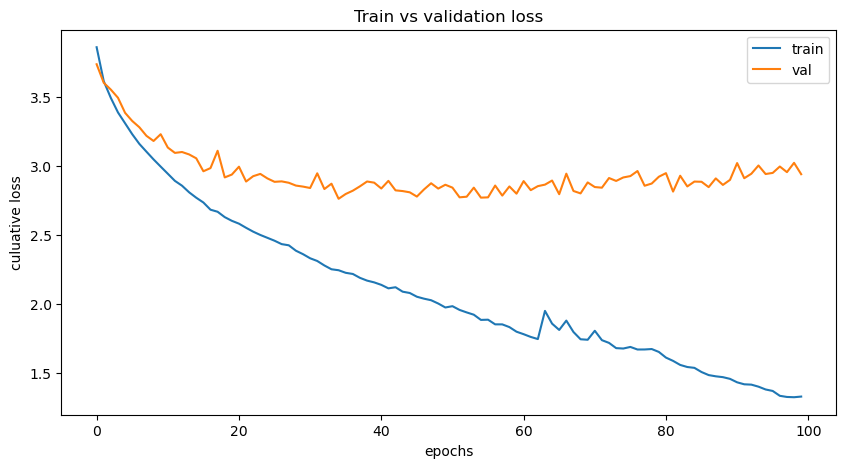

In [13]:
plt.figure(figsize=(10,5))
plt.title("Train vs validation loss")
plt.plot(train_losses,label="train")
plt.plot(val_losses,label="val")
plt.xlabel("epochs")
plt.ylabel("culuative loss")
plt.legend()
plt.show()